## 2. Exploratory Data Analysis

In [1]:
import numpy as np 
import pandas as pd
from collections import Counter
from wordcloud import WordCloud

import matplotlib.pyplot as plt
import matplotlib.style as style
import seaborn as sns
style.use('seaborn-v0_8-darkgrid')
plt.rcParams['font.family'] = 'monospace'

%matplotlib inline
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore")

import joblib
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, MinMaxScaler, OrdinalEncoder, PolynomialFeatures
from sklearn.compose import make_column_transformer
from sklearn.inspection import permutation_importance
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, make_scorer, confusion_matrix, ConfusionMatrixDisplay
from sklearn.pipeline import make_pipeline
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from scipy.spatial.distance import pdist, squareform, euclidean

RANDOM_STATE = 42

In [2]:
df_movies = pd.read_csv('../data/cleaned/cleaned_movies_details.csv')
df_movies_rating = pd.read_csv('../data/cleaned/cleaned_movies_for_rating.csv')
df_rating = pd.read_csv('../data/cleaned/cleaned_user_rating.csv')
df_rating.rename(columns={'rating': 'user_rating'}, inplace=True)
df_merged = pd.merge(df_rating, df_movies_rating, on='movie_id')

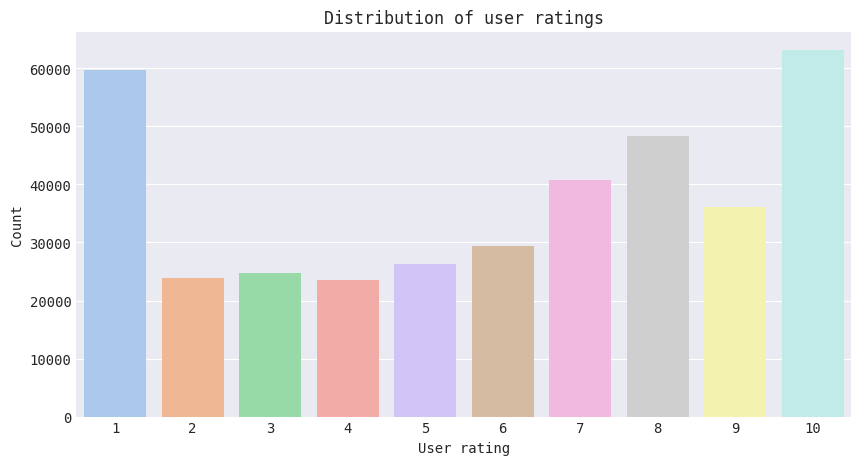

In [3]:
plt.figure(figsize=(10, 5))
sns.countplot(x='user_rating', data=df_merged, palette='pastel')
plt.title('Distribution of user ratings')
plt.xlabel('User rating')
plt.ylabel('Count')
plt.show()

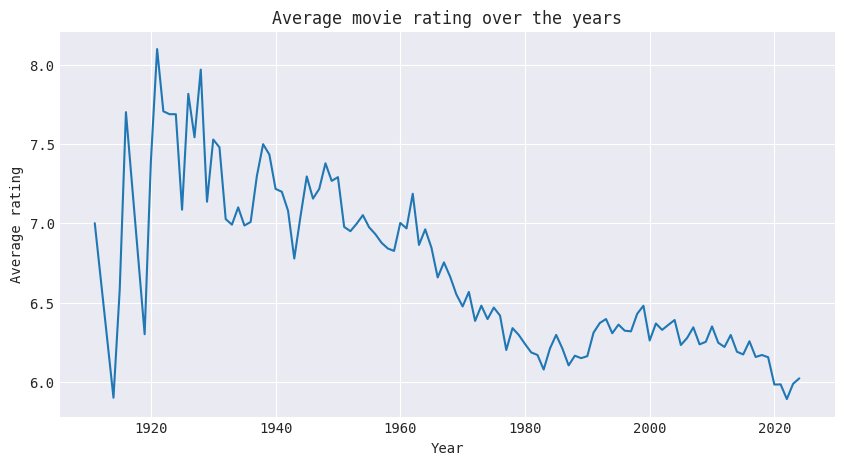

In [4]:
avg_ratings_year = df_merged.groupby('year')['rating'].mean().reset_index()
plt.figure(figsize=(10, 5))
plt.plot(avg_ratings_year['year'], avg_ratings_year['rating'], linestyle='-')
plt.title('Average movie rating over the years')
plt.xlabel('Year')
plt.ylabel('Average rating')
plt.grid(True)
plt.show()

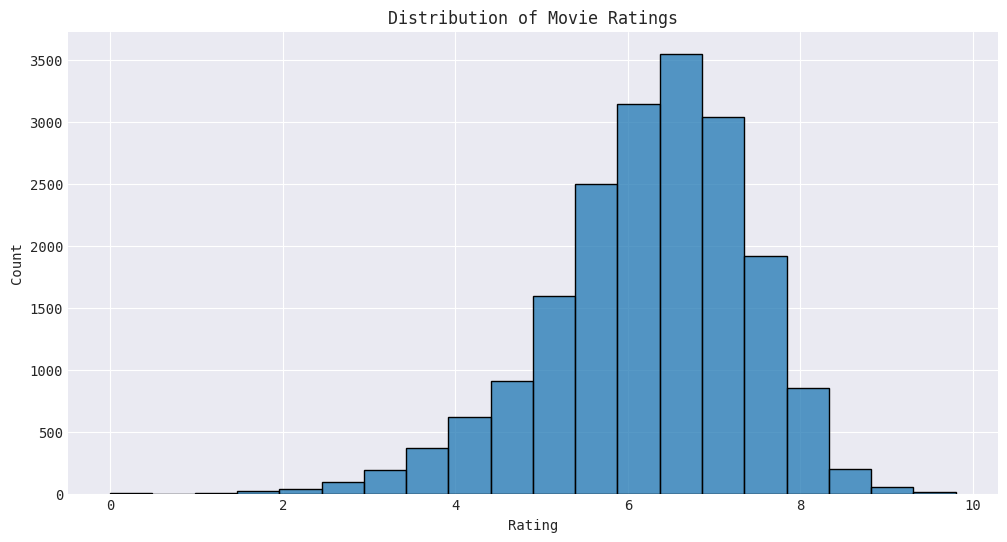

In [29]:
plt.figure(figsize=(12, 6))
sns.histplot(data=df_movies, x='rating', bins=20)
plt.title('Distribution of Movie Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

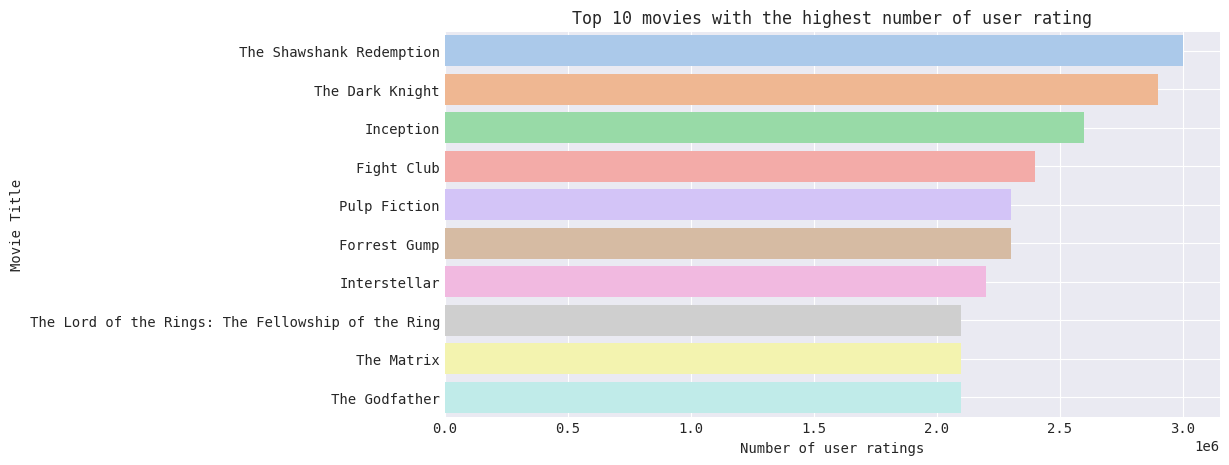

In [5]:
top_rated_movies_corrected = df_movies[['title', 'num_rating']].sort_values(by='num_rating', ascending=False).head(10)
plt.figure(figsize=(10, 5))
sns.barplot(x=top_rated_movies_corrected['num_rating'], y=top_rated_movies_corrected['title'], palette='pastel')
plt.title('Top 10 movies with the highest number of user rating')
plt.xlabel('Number of user ratings')
plt.ylabel('Movie Title')
plt.grid(True)
plt.show()

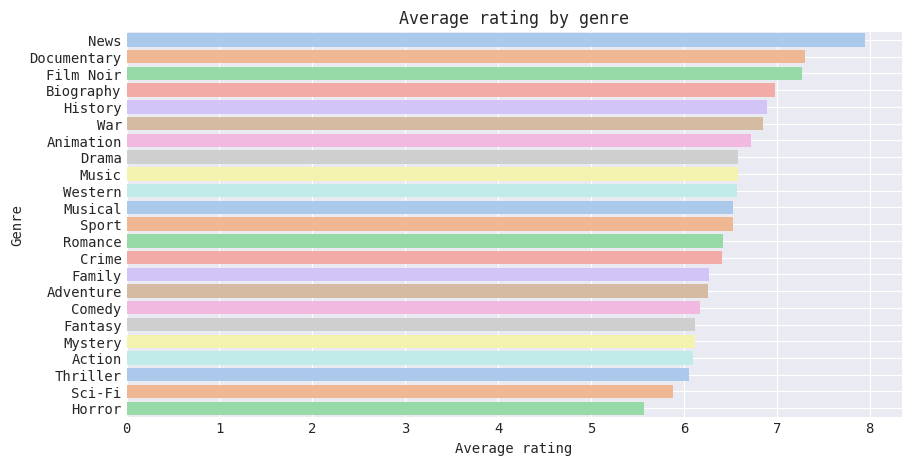

In [6]:
genres = df_movies_rating['genres'].apply(lambda x: x.split(','))
genres_list = []
for genre in genres:
    genres_list.extend(genre)
unique_genres = list(set(genres_list))

genre_rating = {}
for genre in unique_genres:
    genre_rating[genre] = df_merged[df_merged['genres'].apply(lambda x: genre in x)]['rating'].mean()

sorted_genre_rating = sorted(genre_rating.items(), key=lambda x: x[1], reverse=True)
genres, ratings = zip(*sorted_genre_rating)

plt.figure(figsize=(10, 5))
sns.barplot(x=np.array(ratings), y=np.array(genres), palette='pastel')
plt.title('Average rating by genre')
plt.xlabel('Average rating')
plt.ylabel('Genre')
plt.grid(True)
plt.show()

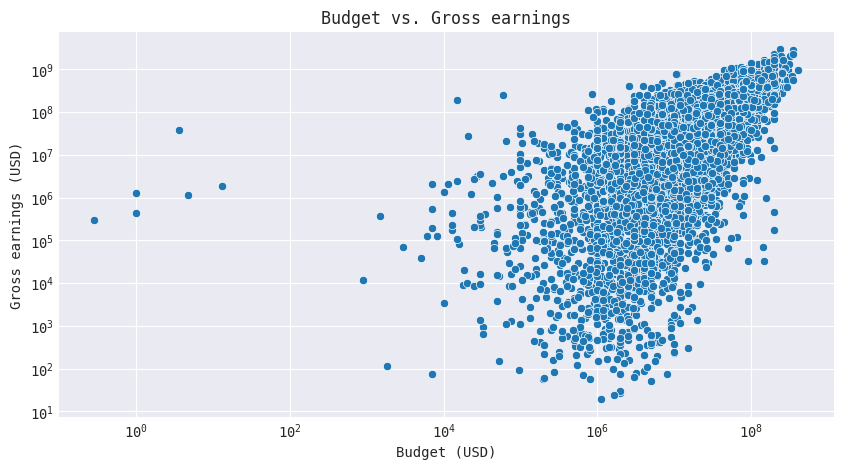

In [7]:
# Relationship between budget and gross earnings for movies
# Filtering out movies without budget or gross information
budget_gross_df = df_movies_rating[(df_movies_rating['budget_usd'] > 0) & (df_movies_rating['gross_usd'] > 0)]
plt.figure(figsize=(10, 5))
sns.scatterplot(x='budget_usd', y='gross_usd', data=budget_gross_df, palette='pastel')
plt.title('Budget vs. Gross earnings')
plt.xlabel('Budget (USD)')
plt.ylabel('Gross earnings (USD)')
plt.xscale('log')
plt.yscale('log')
plt.grid(True)
plt.show()

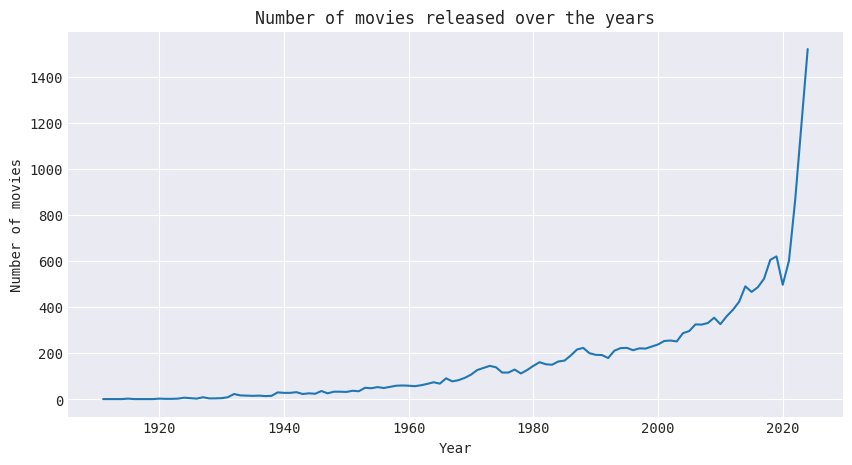

In [8]:
movies_from_1910 = df_movies[df_movies['year'] >= 1910]

movies_per_year = movies_from_1910.groupby('year')['title'].count()

plt.figure(figsize=(10, 5))
movies_per_year.plot(kind='line')
plt.title('Number of movies released over the years')
plt.xlabel('Year')
plt.ylabel('Number of movies')
plt.grid(True)
plt.show()

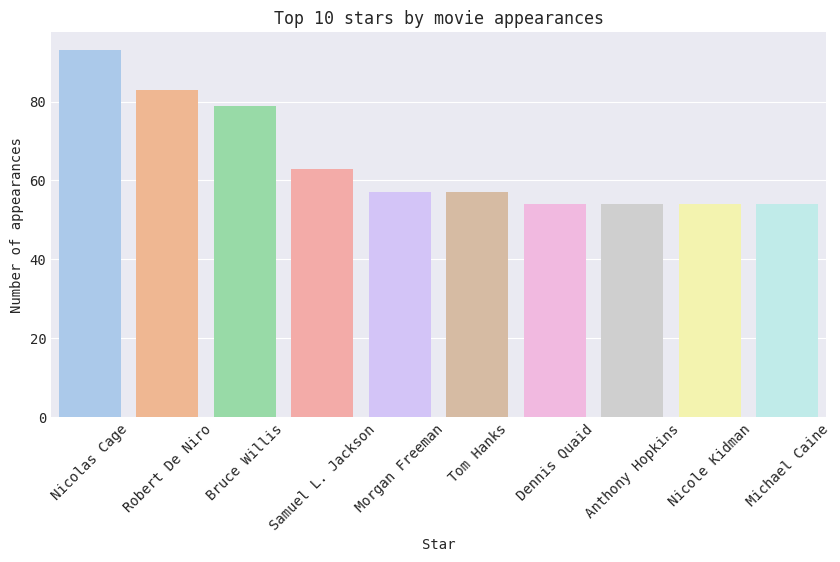

In [9]:
df_movies['stars'] = df_movies['stars'].apply(lambda x: x.split(',') if isinstance(x, str) else [])

list_of_stars = sum(df_movies['stars'], [])

star_counts_corrected = pd.Series(list_of_stars).value_counts().head(10)

plt.figure(figsize=(10, 5))
sns.barplot(x=star_counts_corrected.index, y=star_counts_corrected.values, palette='pastel')
plt.title('Top 10 stars by movie appearances')
plt.xlabel('Star')
plt.ylabel('Number of appearances')
plt.xticks(rotation=45)
plt.show()

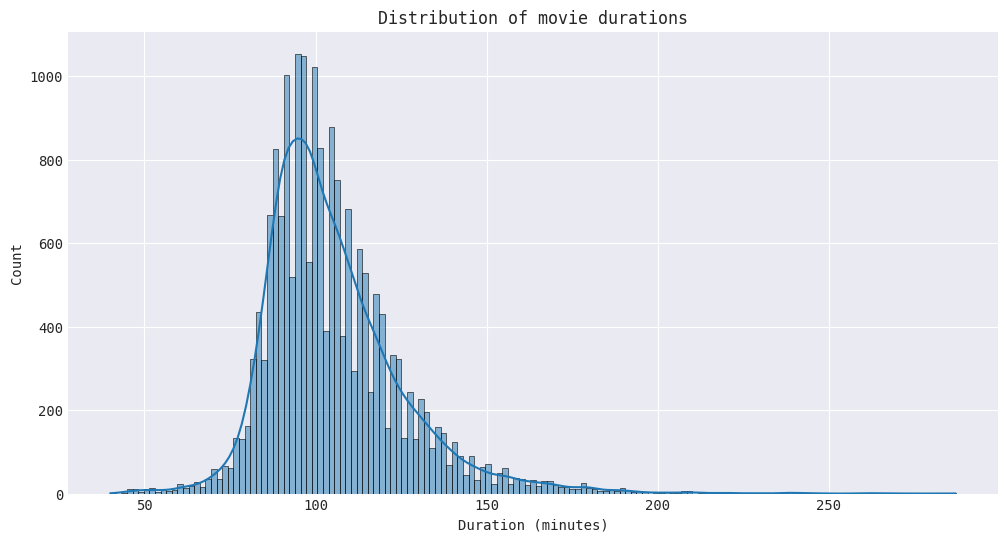

In [10]:
filtered_movies = df_movies[df_movies['duration'] < 300]

plt.figure(figsize=(12, 6))
sns.histplot(filtered_movies['duration'].dropna(), kde=True, palette='pastel')
plt.title('Distribution of movie durations')
plt.xlabel('Duration (minutes)')
plt.ylabel('Count')
plt.show()

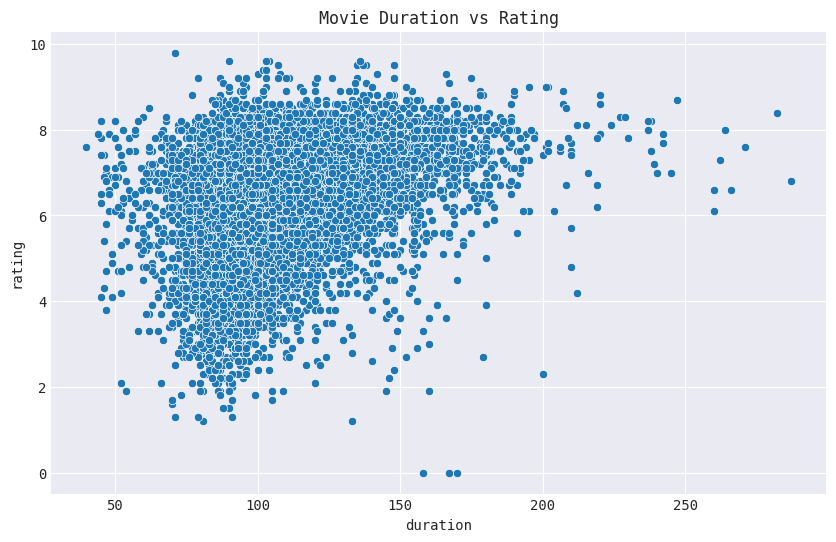

In [35]:
# Duration vs Rating correlation
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_movies, x=filtered_movies['duration'], y=filtered_movies['rating'])
plt.title('Movie Duration vs Rating')
plt.show()

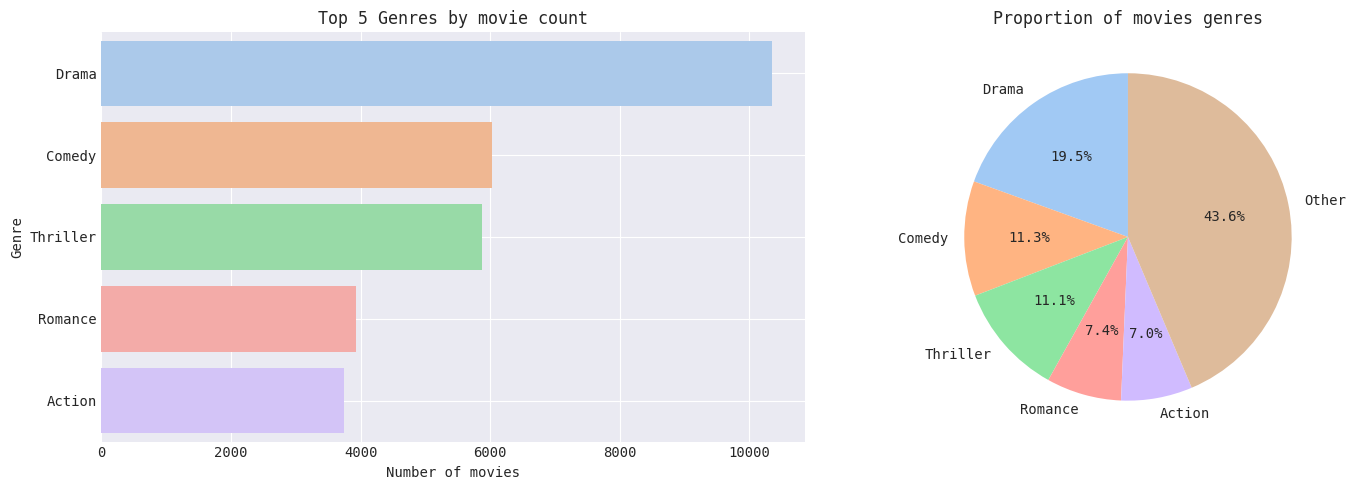

In [12]:
genre_counts = Counter(genres_list)
genre_counts_df = pd.DataFrame(genre_counts.items(), columns=['Genre', 'Count']).sort_values(by='Count', ascending=False)

top_genres = genre_counts_df.head(5)
other_genres_count = genre_counts_df['Count'][5:].sum()

other_df = pd.DataFrame({'Genre': ['Other'], 'Count': [other_genres_count]})

top_genres_with_other = pd.concat([top_genres, other_df], ignore_index=True)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

sns.barplot(x='Count', y='Genre', data=top_genres, palette='pastel', ax=ax1)
ax1.set_title('Top 5 Genres by movie count')
ax1.set_xlabel('Number of movies')
ax1.set_ylabel('Genre')
ax1.grid(True)

ax2.pie(top_genres_with_other['Count'], labels=top_genres_with_other['Genre'], 
        autopct='%1.1f%%', startangle=90, colors=sns.color_palette('pastel', len(top_genres_with_other)))
ax2.set_title('Proportion of movies genres')

plt.tight_layout()
plt.show()

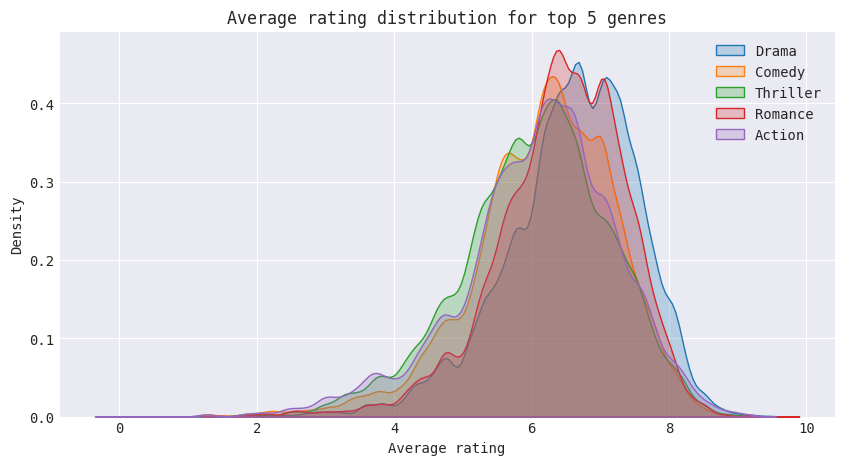

In [13]:
# Average rating distribution for top 5 genres
top_5_genres = list(genre_counts_df.head(5)['Genre'])
plt.figure(figsize=(10, 5))
for genre in top_5_genres:
    subset = df_merged[df_merged['genres'].apply(lambda x: genre in x)]
    sns.kdeplot(subset['rating'], label=genre, shade=True)
plt.title('Average rating distribution for top 5 genres')
plt.xlabel('Average rating')
plt.ylabel('Density')
plt.legend()
plt.show()

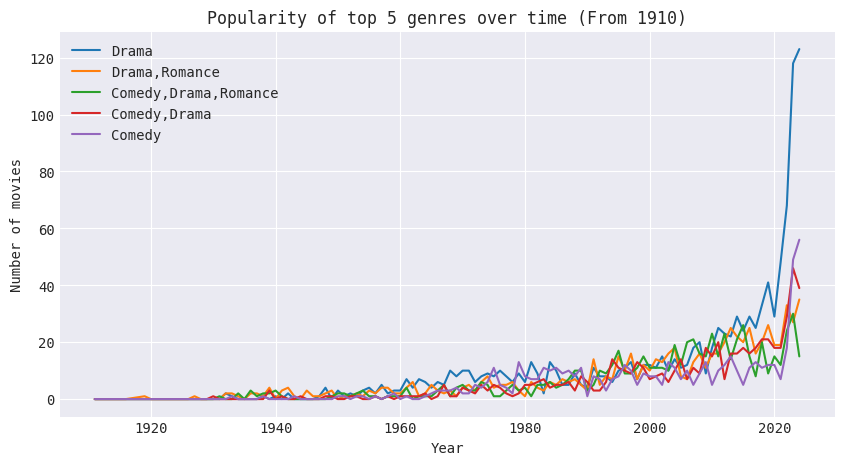

In [14]:
# Top 5 genres over time (from 1910)
genre_yearly = df_movies_rating.explode('genres').groupby(['year', 'genres']).size().unstack().fillna(0)

genre_yearly_from_1910 = genre_yearly[genre_yearly.index >= 1910]

top_genres_from_1910 = genre_yearly_from_1910.sum().nlargest(5).index

top_genres_over_time_from_1910 = genre_yearly_from_1910[top_genres_from_1910]

plt.figure(figsize=(10, 5))
for genre in top_genres_from_1910:
    plt.plot(top_genres_over_time_from_1910.index, top_genres_over_time_from_1910[genre], label=genre)

plt.title('Popularity of top 5 genres over time (From 1910)')
plt.xlabel('Year')
plt.ylabel('Number of movies')
plt.legend()
plt.grid(True)
plt.show()

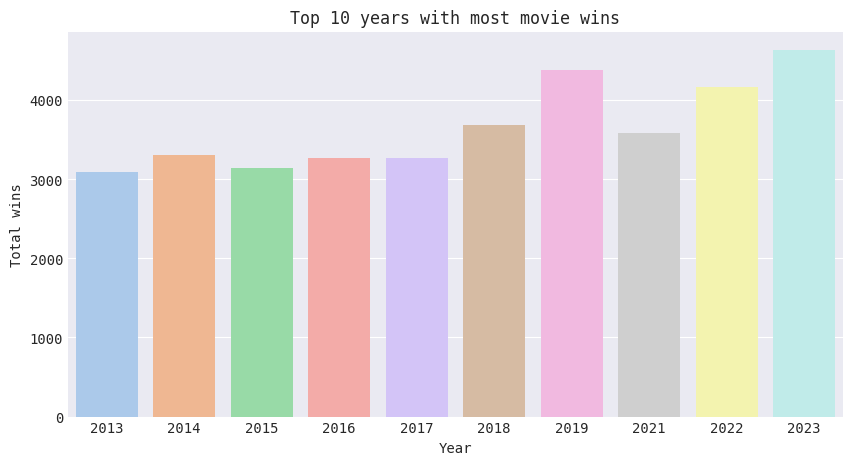

In [15]:
# Top 10 years with the most movie wins (awards)
top_winning_years = df_movies.groupby('year')['win'].sum().sort_values(ascending=False).head(10)
plt.figure(figsize=(10, 5))
sns.barplot(x=top_winning_years.index, y=top_winning_years.values, palette='pastel')
plt.title('Top 10 years with most movie wins')
plt.xlabel('Year')
plt.ylabel('Total wins')
plt.show()

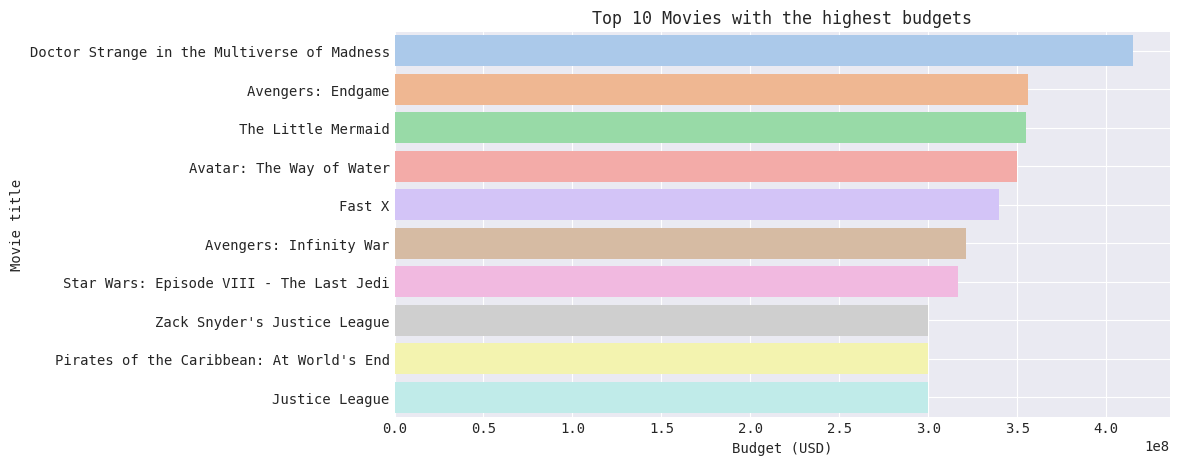

In [16]:
# the top 10 movies with the highest budgets
top_10_budget_movies = df_movies_rating.sort_values(by='budget_usd', ascending=False).head(10)

plt.figure(figsize=(10, 5))
sns.barplot(x='budget_usd', y='title', data=top_10_budget_movies, palette='pastel')
plt.title('Top 10 Movies with the highest budgets')
plt.xlabel('Budget (USD)')
plt.ylabel('Movie title')
plt.grid(True)
plt.show()

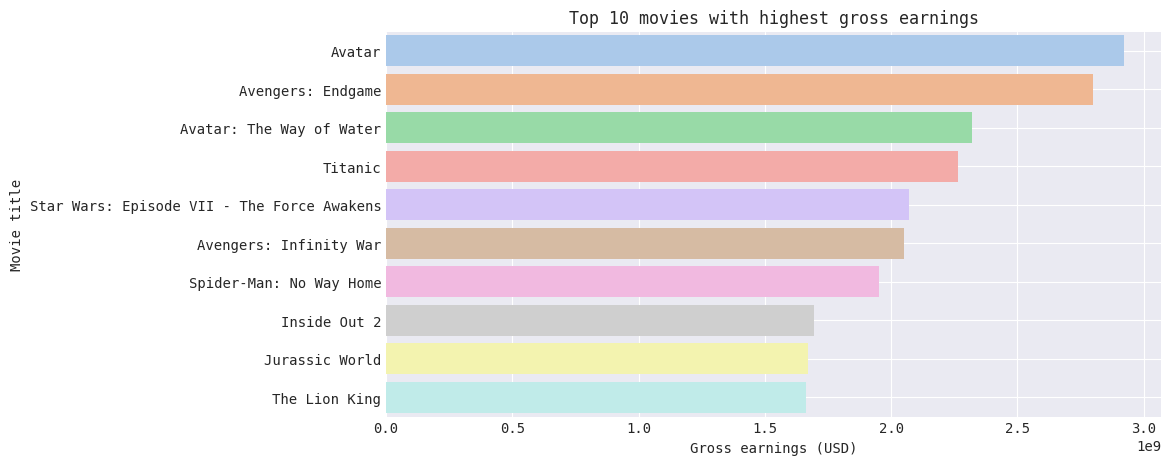

In [17]:
# Top 10 movies with the highest gross earnings
top_grossing_movies = df_movies[['title', 'gross_usd']].sort_values(by='gross_usd', ascending=False).head(10)

plt.figure(figsize=(10, 5))
sns.barplot(x='gross_usd', y='title', data=top_grossing_movies, palette='pastel')
plt.title('Top 10 movies with highest gross earnings')
plt.xlabel('Gross earnings (USD)')
plt.ylabel('Movie title')
plt.grid(True)
plt.show()

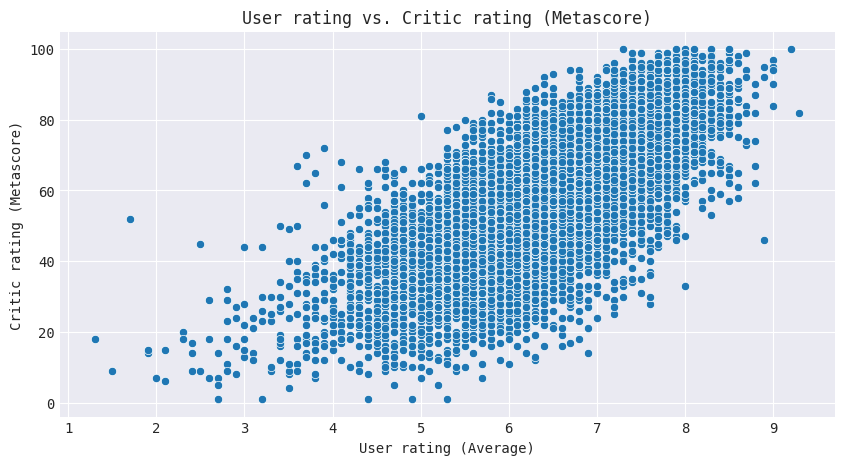

In [18]:
# Analyzing the relationship between user ratings and metascore
# Filtering out movies with available user ratings and metascore
valid_ratings_df = df_movies.dropna(subset=['rating', 'metascore'])

# Calculating the correlation between user ratings and metascore
correlation = valid_ratings_df[['rating', 'metascore']].corr()

plt.figure(figsize=(10, 5))
sns.scatterplot(x='rating', y='metascore', data=valid_ratings_df)
plt.title('User rating vs. Critic rating (Metascore)')
plt.xlabel('User rating (Average)')
plt.ylabel('Critic rating (Metascore)')
plt.grid(True)
plt.show()

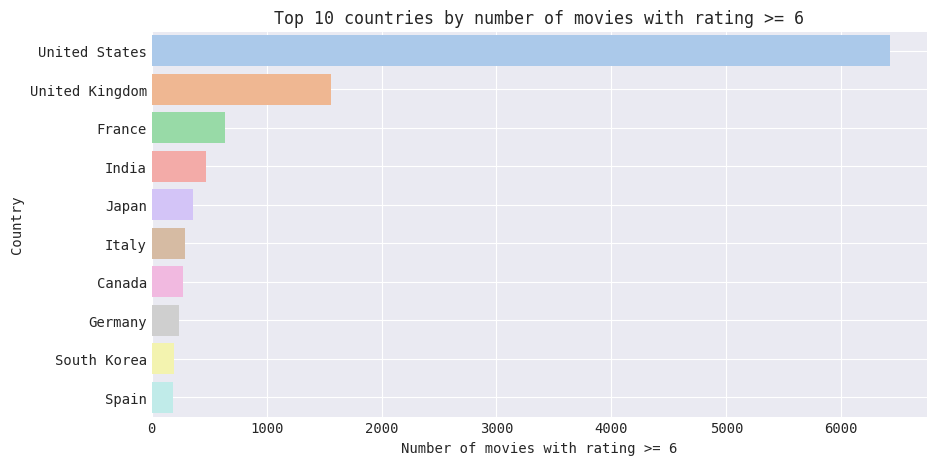

In [19]:
# Analyzing and visualizing the 'country' column from the movies dataset with number of movies with rating > 7
high_rating_movies = df_movies[df_movies['rating'] >= 6]

# Count the number of movies with rating > 7 for each country
country_counts = high_rating_movies['country'].value_counts()
top_countries = country_counts.head(10)

plt.figure(figsize=(10, 5))
sns.barplot(x=top_countries.values, y=top_countries.index, palette='pastel')
plt.title('Top 10 countries by number of movies with rating >= 6')
plt.xlabel('Number of movies with rating >= 6')
plt.ylabel('Country')
plt.grid(True)
plt.show()

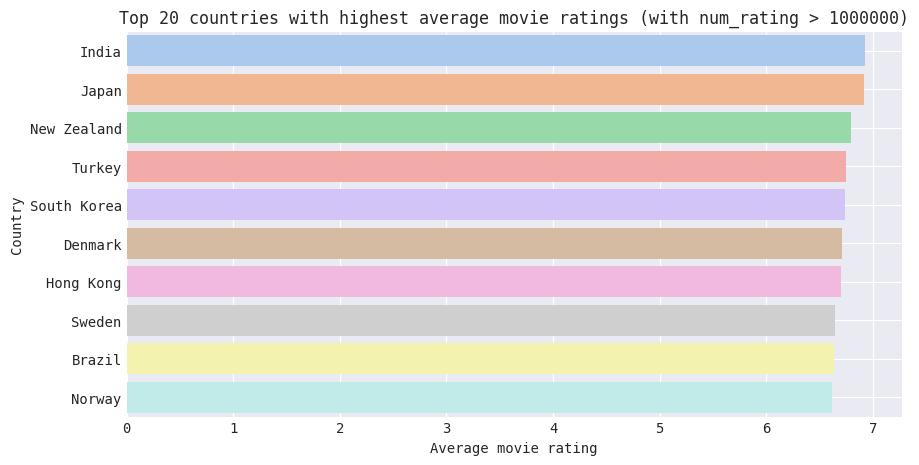

In [20]:
# Analyzing the average ratings of movies from the top 20 countries with the highest average movie ratings

# Filter out countries with fewer than 1000000 total user ratings
country_rating_counts = df_movies.groupby('country')['num_rating'].sum()
eligible_countries = country_rating_counts[country_rating_counts >= 1000000].index

# Calculate the average rating for eligible countries
average_ratings_by_country = (
    df_movies[df_movies['country'].isin(eligible_countries)]
    .groupby('country')['rating']
    .mean()
    .sort_values(ascending=False)
)

top_countries_high_rating = average_ratings_by_country.head(10)

plt.figure(figsize=(10, 5))
sns.barplot(x=top_countries_high_rating.values, y=top_countries_high_rating.index, palette='pastel')
plt.title('Top 20 countries with highest average movie ratings (with num_rating > 1000000)')
plt.xlabel('Average movie rating')
plt.ylabel('Country')
plt.grid(True)

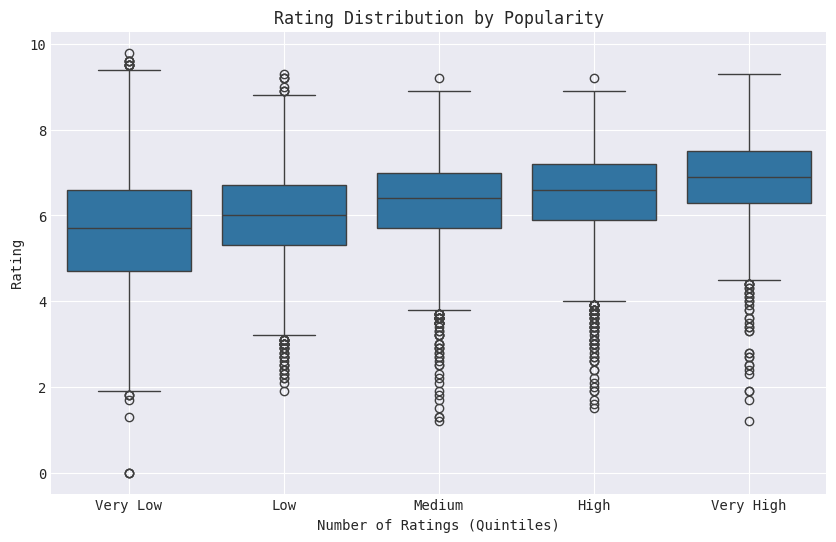

In [41]:
# Analysis of rating bias based on number of ratings
df_movies['rating_bucket'] = pd.qcut(df_movies['num_rating'], q=5, labels=['Very Low', 'Low', 'Medium', 'High', 'Very High'])

plt.figure(figsize=(10, 6))
sns.boxplot(data=df_movies, x='rating_bucket', y='rating')
plt.title('Rating Distribution by Popularity')
plt.xlabel('Number of Ratings (Quintiles)')
plt.ylabel('Rating')
plt.grid(True)
plt.show()

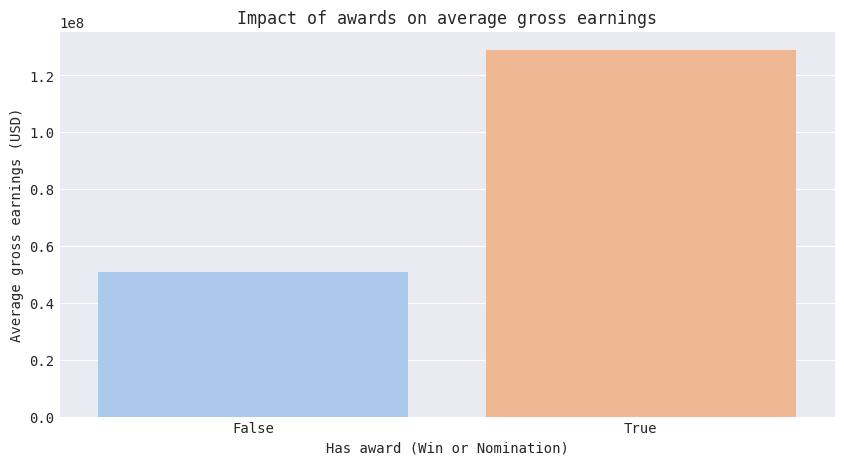

In [21]:
# Analyzing the impact of winning an Oscar award on the average gross earnings of movies
df_movies['has_award'] = (df_movies['oscar']) > 0
award_impact_on_earnings = df_movies.groupby('has_award')['gross_usd'].mean()

plt.figure(figsize=(10, 5))
sns.barplot(x=award_impact_on_earnings.index, y=award_impact_on_earnings.values, palette='pastel')
plt.title('Impact of awards on average gross earnings')
plt.xlabel('Has award (Win or Nomination)')
plt.ylabel('Average gross earnings (USD)')
plt.show()

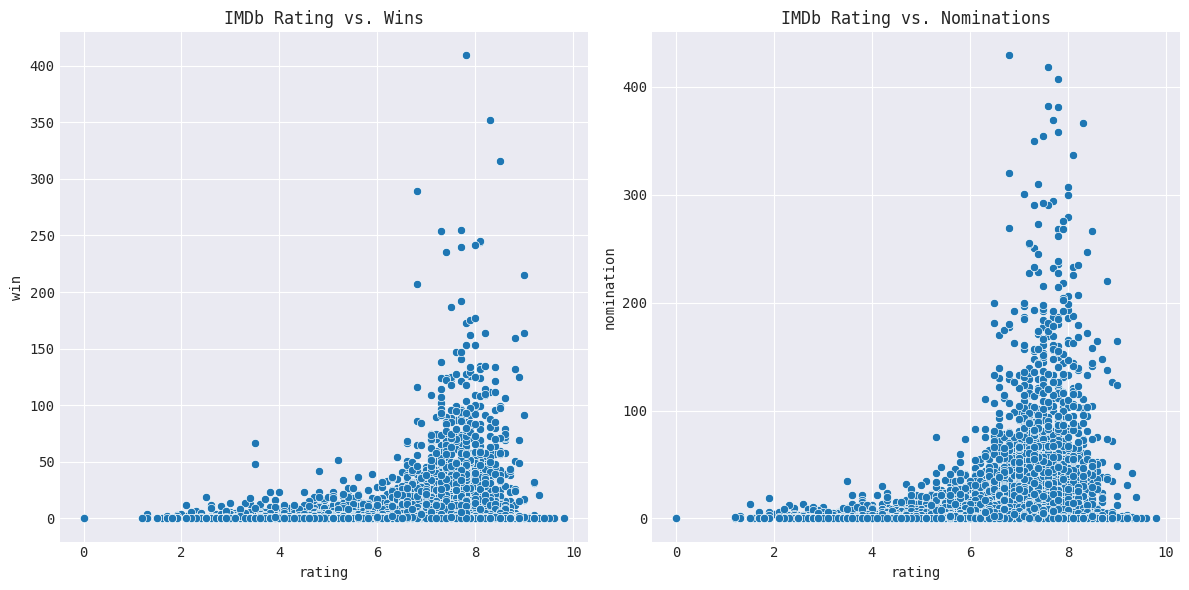

In [22]:
# Analyzing the impact of win and nominations on the movie ratings
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

sns.scatterplot(x='rating', y='win', data=df_movies, ax=axes[0], palette='pastel')
axes[0].set_title('IMDb Rating vs. Wins')
axes[0].grid(True)

sns.scatterplot(x='rating', y='nomination', data=df_movies, ax=axes[1], palette='pastel')
axes[1].set_title('IMDb Rating vs. Nominations')
axes[1].grid(True)

plt.tight_layout()
plt.show()

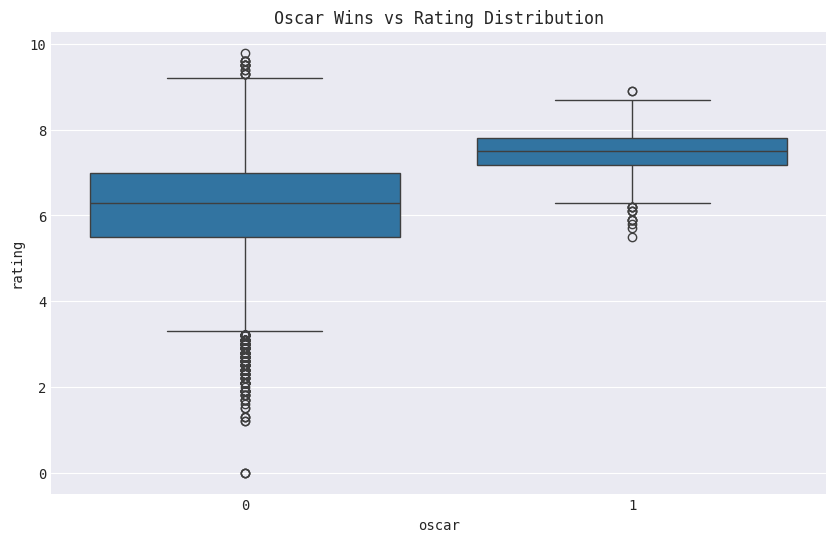

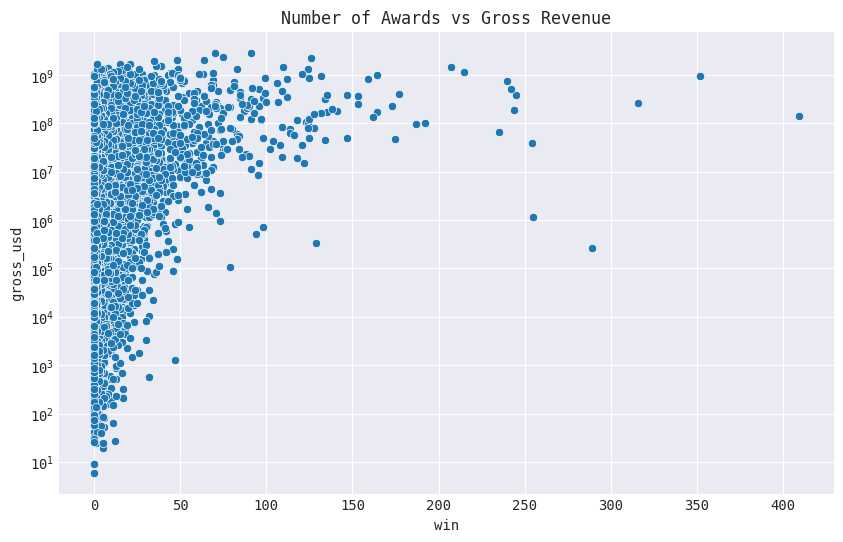

In [37]:
# Correlation between awards and ratings
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_movies, x='oscar', y='rating')
plt.title('Oscar Wins vs Rating Distribution')

# Awards vs Revenue
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_movies, x='win', y='gross_usd')
plt.title('Number of Awards vs Gross Revenue')
plt.yscale('log')
plt.grid(True)
plt.show()

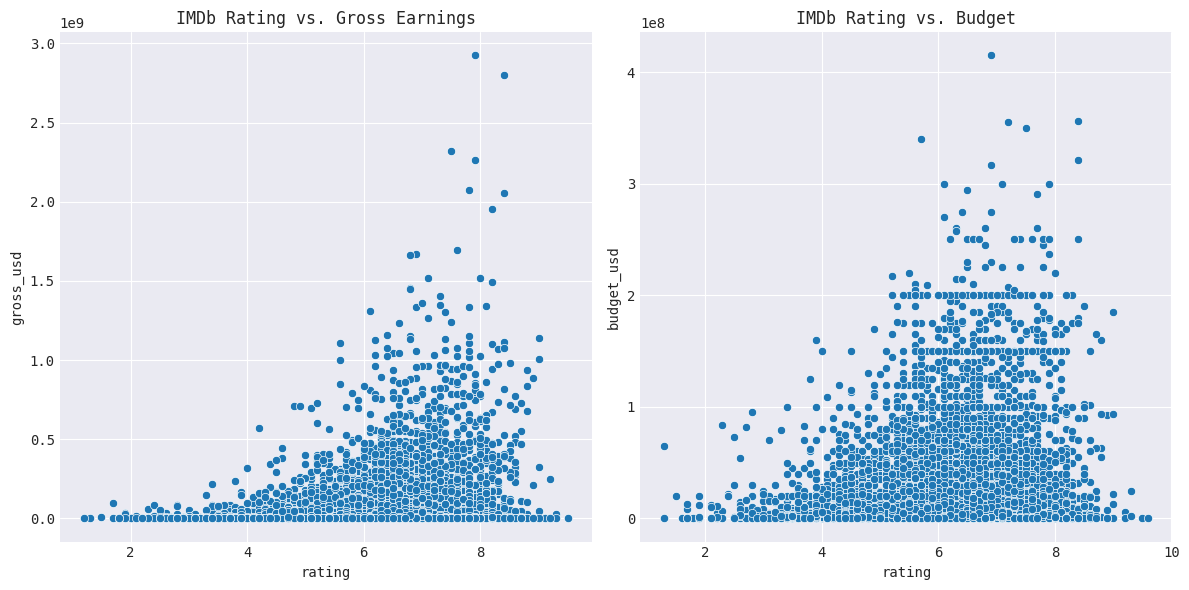

In [23]:
# Analyzing the impact of ratings on the movie gross earnings and the impact of ratings on the movie budget
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

sns.scatterplot(x='rating', y='gross_usd', data=df_movies, ax=axes[0], palette='Blues_d')
axes[0].set_title('IMDb Rating vs. Gross Earnings')
axes[0].grid(True)

sns.scatterplot(x='rating', y='budget_usd', data=df_movies, ax=axes[1], palette='Blues_d')
axes[1].set_title('IMDb Rating vs. Budget')
axes[1].grid(True)

plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'Rating Distribution: Oscar vs Non-Oscar Movies')

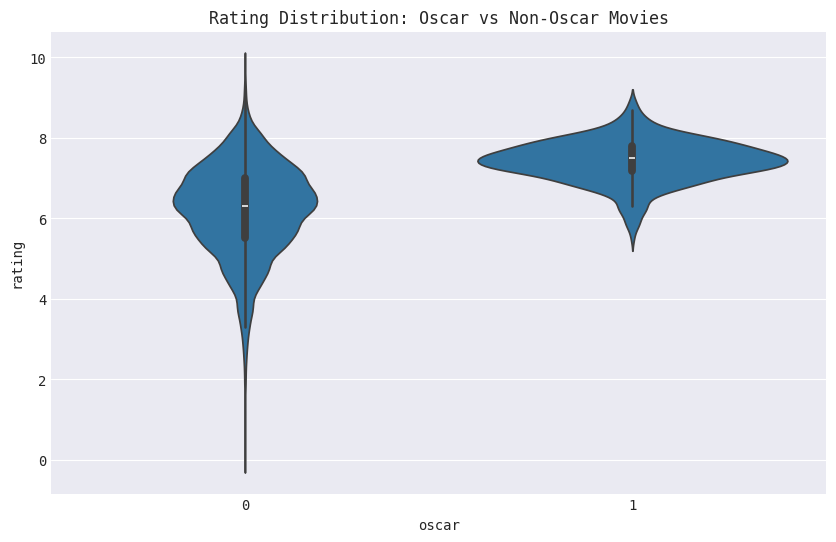

In [40]:
# Compare ratings for movies with/without awards
plt.figure(figsize=(10, 6))
sns.violinplot(data=df_movies, x='oscar', y='rating')
plt.title('Rating Distribution: Oscar vs Non-Oscar Movies')

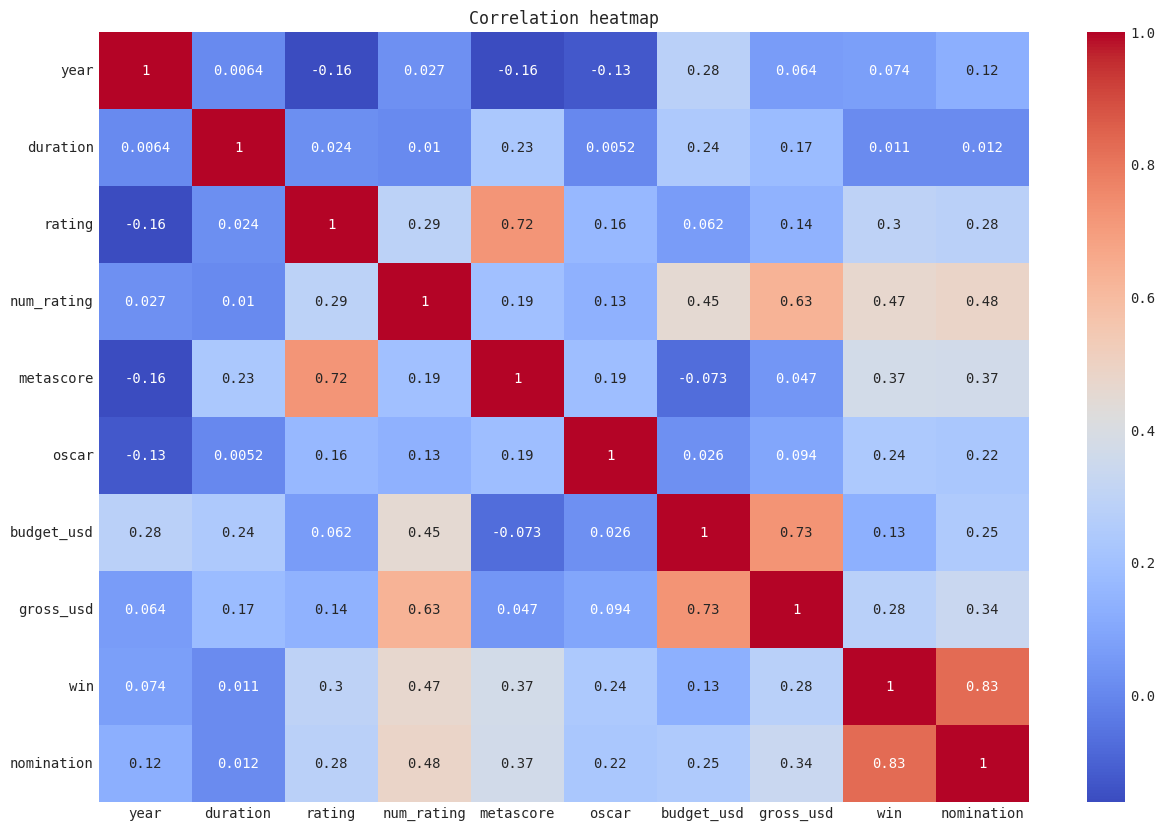

In [25]:
numeric_cols = df_movies.select_dtypes(include=['float64', 'int64']).columns
corr_matrix = df_movies[numeric_cols].corr()

fig, ax = plt.subplots(figsize=(15, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
ax.set(title='Correlation heatmap')
plt.show()

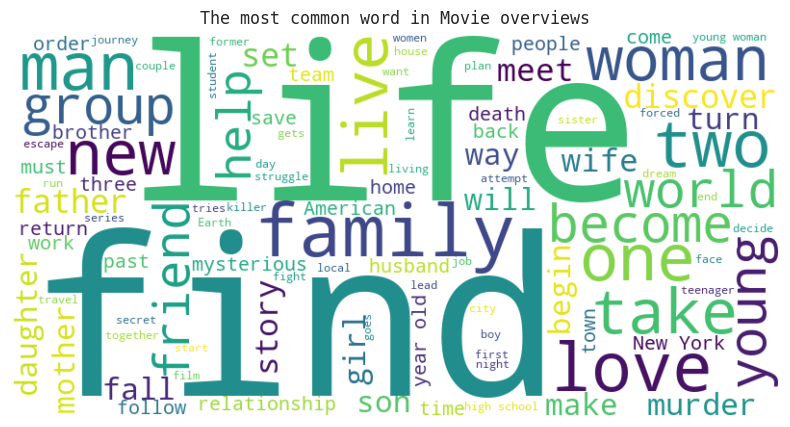

In [26]:
overview_text = ' '.join(df_movies['overview'].dropna())
wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='viridis', 
                      max_words=100, stopwords=None).generate(overview_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('The most common word in Movie overviews')
plt.show()